![Machine Learning for Scientists in a hurry](./fig/Title_ML.png)

# Boilerplate

In [1]:
from IPython.display import Math, HTML, display

def set_css_in_cell_output():
  display(HTML("""<style>
    .div-1 {
        background-color: #EBEBEB;
    }

    .div-2 {
    	background-color: #ABBAEA;
    }

    .div-3 {
    	background-color: #FBD603;
    }
    .div-white {
    	background-color: #FBFBFB;
    }
    h1 {
      color: #002855;
    }
    h2 {
      color: #002855;
    }
</style>
"""))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)


In [2]:
!pip install watermark

In [3]:
!if [ ! -f helpers.py ]; then wget "https://raw.githubusercontent.com/romerogroup/Notebooks_4SIAH/main/Machine_Learning/helpers.py"; fi

<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 60%; padding: 5px">
  <h1 id="subtitle">Chapter 7. Dimensionality Reduction</h1>
  <h2 id="subtitle">Guillermo Avendaño Franco<br>Aldo Humberto Romero</h2>
  <br>
  <img src="fig/1-line logotype124-295.png" alt="Scientific Computing with Python" style="width:50%" align="left">
  </div>
  <div style="border: none; float: left; width: 30%; padding: 5px">
  <img src="fig/SCPython.png" alt="Scientific Computing with Python" style="width:100%">
  </div>
</div>

## Setup

In [4]:
%load_ext watermark

In [5]:
%watermark

Last updated: 2023-10-22T18:10:38.472577-04:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.14.0

Compiler    : Clang 11.0.3 (clang-1103.0.32.62)
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [6]:
import time
start = time.time()
chapter_number = 7
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import sklearn

In [8]:
%watermark -iv

sklearn   : 1.3.0
matplotlib: 3.8.0
numpy     : 1.25.2



# Where we are on the map?

<img src="fig/ml_map.png" width="700" height="200" title="Precision vs Recall" alt="Precision vs Recall"></a>

# Dimensionality Reduction

In machine learning is not unusual the number of features been in the order hundreds, thousands or even more. 
However, having that extra data is not making things better, and it can surely make things worst. 

"High-dimensional" datasets can be quite hard to work with and reason about. High dimensional datasets also pose specific challenges to many machine learning models (see **[The Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)**). To work around these challenges, it's often helpful to reduce the number of dimensions required to express a given dataset. That reduction is trying to solve two problems. The dimensionality reduction itself and the focus on more relevant features that maximize the probability of successful classifications.

## Principal Component Analysis

One popular way to reduce the dimensionality of a dataset is to use a technique called [**Principal Component Analysis**](https://en.wikipedia.org/wiki/Principal_component_analysis). PCA tries to find a lower dimensional representation of a dataset by projecting that dataset down into a smaller dimensional space in a way that minimizes the loss of information.

To get an intuition about PCA, suppose you have points in two dimensions, and you wish to reduce the dimensionality of your dataset to a single dimension. To do so, you could find the center of the points and then create a line $L$ with a random orientation that passes through that center. One can then project each point onto $L$ such that an imaginary line between the point and $L$ form a right angle. Within this "projection", each 2D point can be represented with just its position along the 1D $L$, effectively giving us a 1D representation of the point's position in its original space. Furthermore, we can use the difference between the largest and smallest values of points projected onto $L$ as a measure of the amount of "variance" or "spread" within the data captured in $L$&mdash;the greater this spread, the greater the amount of "signal" from the original dataset is represented in the projection.

If one were to slowly rotate $L$ and continue measuring the delta between the greatest and smallest values on $L$ at each orientation, one could find the orientation of the projection line that minimizes information loss. (This line of minimal information loss is shown in pink below.) Once that line is discovered, we can project all of our points onto that lower-dimensional embedding (see the red points below when the black line is colinear with the pink line):

<img src='fig/pca.gif'>





For a beginner-friendly deep dive into the mechanics behind this form of dimension reduction, check out Josh Starmer's [step-by-step guide to PCA](https://www.youtube.com/watch?v=FgakZw6K1QQ).


PCA (Principal Component Analysis) converts a dataset of possibly correlated features into a dataset of linearly uncorrelated features called principal components. is equivalent to **Singular Value Decomposition** (SVD):

$$\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^*$$

Formally, the singular value decomposition of an $m \times n$ real or complex matrix $\mathbf{M}$ is a factorization of the form $\mathbf{U\Sigma V^*}$, where $\mathbf{U}$ is an $m \times m$ real or complex **unitary matrix**, $\mathbf{\Sigma}$ is an $m \times n$ **rectangular diagonal matrix** with non-negative real numbers on the diagonal, and $\mathbf{V}$ is an $n \times n$ real or complex unitary matrix. The diagonal entries $\sigma_i$ of $\mathbf{\Sigma}$ are known as the **singular values** of $\mathbf{M}$. The columns of $\mathbf{U}$ and the columns of $\mathbf{V}$ are called the **left-singular vectors** and **right-singular vectors** of $\mathbf{M}$, respectively.

<img src="fig/1280px-Singular_value_decomposition_visualisation.svg.png" alt="SVD" style="width:400px">

For Real-valued matrices, the conjugate transpose $\mathbf{V}^*$ becomes just the transpose $\mathbf{V}^T$ and the decomposition is:

$$\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$$

The value returned from `transform` is the matrix $\mathbf{U}$. The parameter `n_components` is the number of components to keep. if `n_components` is not set, all components are kept; it means that the result of `transform` is a matrix $n \times n$ (if $d \geq n$) or $n \times d$ (if $d < n$).

The values in the attribute `explained_variance_` are related to $\boldsymbol{\Sigma}$ in the SVD decomposition. Finally, the values in the attribute `components_` are related to $\mathbf{V}^T$.

The optional parameter `whiten=True` makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models downstream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

# Dimensionality reduction of MNIST dataset

The MNIST dataset contains 70000 images of hand-written digits. Each image is a matrix of 28x28 grayscale pixels. The value of each pixel goes from 0 to 255.

There is more information available in the MNIST dataset repository:
http://yann.lecun.com/exdb/mnist/

Let's first fetch the dataset from the internet (which may take a while, note the asterisk [*]):

In [9]:
#from sklearn.datasets import fetch_openml
#X_all, y_all = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='./data')

# The shape of input and labels
#print(X_all.shape)
#print(y_all.shape)

In [10]:
import os
import gzip
from scipy.io import arff
import pandas as pd

In [11]:
!if [ ! -f data/mnist_784.arff ]; then wget "https://www.openml.org/data/download/52667/mnist_784.arff" -O ./data/mnist_784.arff; fi

In [12]:
filename = "./data/mnist_784.arff.gz"
url = "https://www.openml.org/data/download/52667/mnist_784.arff"
if os.path.isfile(filename):
    arff_file = gzip.open(filename,'rt')
else:
    arff_file = "./data/mnist_784.arff"
data, meta = arff.loadarff(arff_file)

In [13]:
df=pd.DataFrame(data)

In [14]:
mnist = {}
mnist['data'] = df.drop('class', axis=1).astype('uint8')
mnist['target'] = df['class'].astype('uint8')

In [15]:
X_all = mnist['data']
y_all = mnist['target']

This dataset is ordered, and we will get just part of it to speed up this exercise.

For this, we need to shuffle the entire data and get the first instances.

In [16]:
from sklearn.utils import shuffle

# shuffle dataset (which is sorted!)
X_all, y_all = shuffle(X_all, y_all, random_state=42)

# take only the first instances, to shorten runtime
X = X_all[:1500]
y = y_all[:1500]

# take the other instances for testing
X_test = X_all[1500:]
y_test = y_all[1500:]

From the sklearn documentation:

> Many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

We will then rescale the training data since this is important to improve the performance of the classification algorithm that we will use later.

In [17]:
# Rescale grayscale from -1 to 1
X = X/255.0*2 - 1

In [18]:
X=X.to_numpy()
y=y.to_numpy()

Let's have a look at some of the instances in the dataset we just loaded:

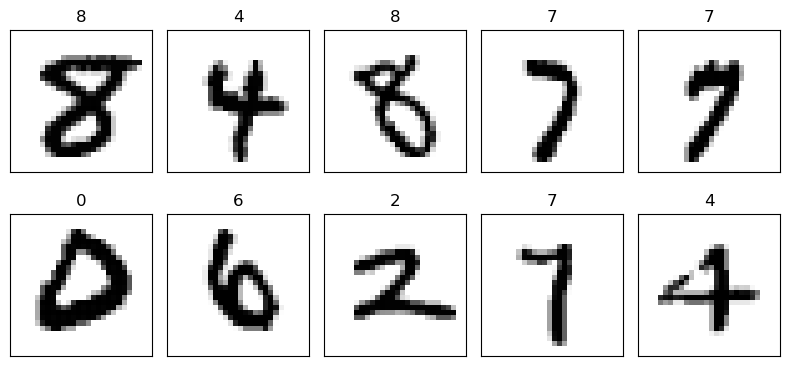

In [19]:
plt.rc("image", cmap="binary")
plt.figure(figsize=(8,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

pca.fit(X)

U = pca.transform(X)
S = pca.explained_variance_
V = pca.components_

print (U.shape)
print (S.shape)
print (V.shape)

(1500, 2)
(2,)
(2, 784)


## PCA using SVD decomposition

The PCA can be obtained from Numpy function `linalg.svg` in that case the X values must be centered, something that the PCA function in Scikit-learn does for you

In [21]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [22]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [23]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [24]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [25]:
X2D_using_svd = X2D

In [26]:
X2D = pca.fit_transform(X)

In [27]:
print(X2D.shape)
X2D[:5]

(1500, 2)


array([[ 6.07877968,  4.11843671],
       [-1.96204896, -4.07698646],
       [-0.68517479,  0.66104464],
       [-3.90475734, -2.94246782],
       [-3.47801963, -2.43582895]])

In [28]:
print(X2D_using_svd.shape)
X2D_using_svd[:5]

(1500, 2)


array([[-6.07877132,  4.11830917],
       [ 1.9620494 , -4.07694401],
       [ 0.68517622,  0.66101962],
       [ 3.90475013, -2.94237969],
       [ 3.47801914, -2.43581028]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general, the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped

## Measuring the data loss from using a PCA

As we are using just 2 dimensions out of the 768 original ones. It is clear that we have to pay a price for that.
We can quantify the loss from the PCA like this:

First, we recover the 3D points projected on the plane (PCA 2D subspace).

In [29]:
X3D_inv = pca.inverse_transform(X2D)

The recovered 3D points are not exactly equal to the original 3D points:

In [30]:
np.allclose(X3D_inv, X)

False

The reconstruction error can be computed by taking the average in the difference between the recreated images and the original ones.

In [31]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

176.6185515954143

Quite a big difference, so the question is: How many components should be good enough? How to quantify "good enough"?
To answer those questions let's first get a visual idea about the transformations involved here.

## Visualizing the transformations

The first row in the figure below shows the first digits on the MNIST database, the second row the back-transformed images using just 2 Principal Components.

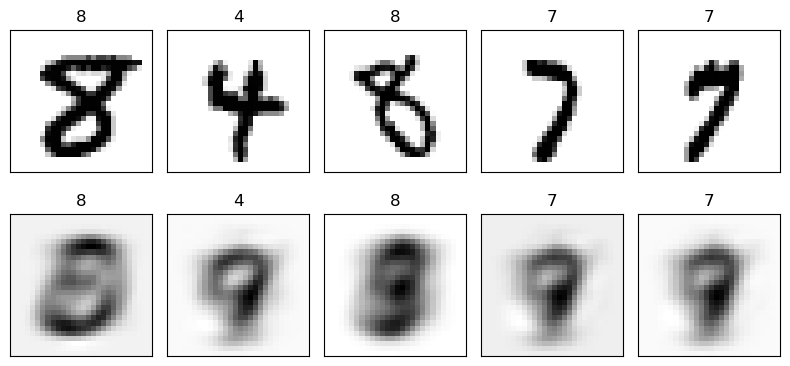

In [32]:
plt.rc("image", cmap="binary")
plt.figure(figsize=(8,4))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
for i in range(5):
    plt.subplot(2,5,5+i+1)
    plt.imshow(X3D_inv[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

The transformed images look noisy, that is because from the 768 pixels we have reduced to just 2, considering that is remarkable that we still see a resemblance of the original digit on the 

Now let's have a look at the most important directions in which the dataset was projected. These directions can be accessed in the $\mathbf{V}^T$ matrix. For doing that we need to construct PCA for all components.

In [33]:
pca_complete = PCA()

pca_complete.fit(X)

Uc = pca_complete.transform(X)
Sc = pca_complete.explained_variance_
Vc = pca_complete.components_

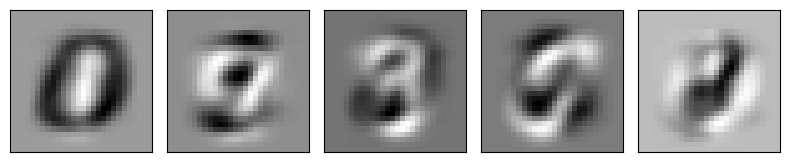

In [34]:
plt.figure(figsize=(8,6))

for i in range(5): # loop over all means
    plt.subplot(1,5,i+1)
    plt.imshow(Vc[i].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

The figures above are just 2D representations of vectors in a 768-dimensional space. They are not meant to be numbers but capture the combination of pixels that maximize the variance in the set.

The later directions (here, from the 100-th on) show noise and small variations between different, but very similar training instances:

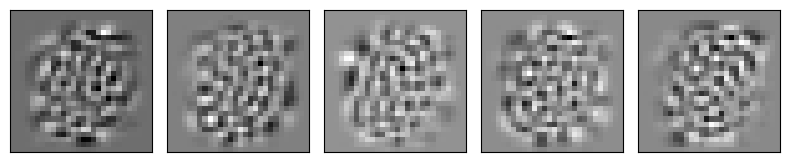

In [35]:
plt.figure(figsize=(8,4))

for i in range(5): # loop over all means
    plt.subplot(1,5,i+1)
    plt.imshow(Vc[100+i].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

## Selecting the right number of components

The number of "interesting" dimensions can be seen from the importance of the found directions.

We can find this information by plotting the `explained_variance_` attribute from the `PCA` variable. This is related to the $\Sigma$ matrix in the following way:

$$\mathbf{ev} = \frac{1}{N} \Sigma^2 $$

To find the most relevant directions, we can use the `explained_variance_` to get 90% of the dataset variance.

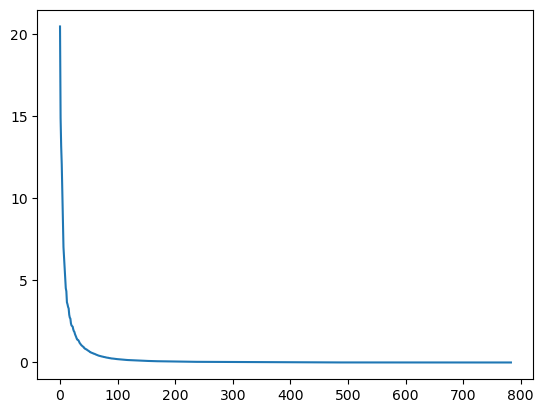

In [36]:
plt.plot(pca_complete.explained_variance_);

80


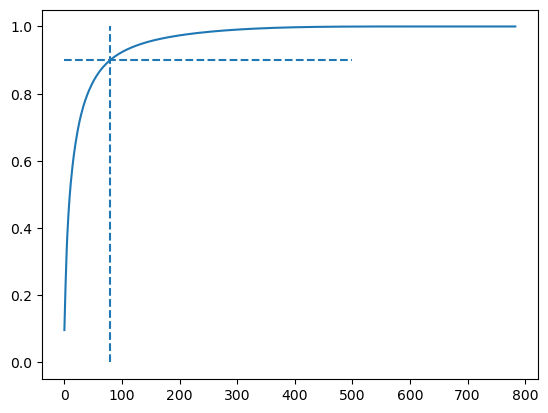

In [37]:
ev_cumsum = np.cumsum(pca_complete.explained_variance_)/(pca_complete.explained_variance_).sum()
ev_at90 = ev_cumsum[ev_cumsum<0.9].shape[0]
print (ev_at90)

plt.plot(ev_cumsum)
plt.vlines(ev_at90, 0, 1, linestyles='dashed')
plt.hlines(0.9, 0, 500, linestyles='dashed');

We can see that the intrinsic dimensionality is not higher than 80, even though the dataset has 784 dimensions.

We can explain that number intuitively, notice that the digits rarely touch the four corners of the picture, leaving many of those pixels zeroed and not adding information to the figure. the center and circular areas around the center provide most of the information about the digits. That is why the first PCA components put special emphasis on them.



We can see that the intrinsic dimensionality is not higher than 80, even though the dataset has 784 dimensions.

We can explain that number intuitively, notice that the digits rarely touch the four corners of the picture, leaving many of those pixels zeroed and not adding information to the figure. the center and circular areas around the center provide most of the information about the digits. That is why the first PCA components put special emphasis on them.

We now know that just 2 components are not enough but 80 components will account for 90% of explained variance in the data, we say that $\mathbf{k_p}$ is the number of components to achieve $p$ % of explained variance.

By setting the parameter `n_components` to $\mathbf{k}$, we limit the number of components to $\mathbf{k}$. At this point, the decomposition is a **Truncated SVD**.

As a consequence, the value returned from `transform` is a matrix $\mathbf{U} \in \mathbb{R}^{n \times k}$, where n is the number of samples and k is the number of components. The number of values in the attribute `explained_variance_`, related to $\boldsymbol{\Sigma}$ in the SVD decomposition, is $\mathbf{k}$. Finally, the values in the attribute `components_` are a matrix $\mathbf{V}^T \in \mathbb{R}^{k \times m}$, where $m$ is the number of features.

In [38]:
from sklearn.decomposition import PCA
pca = PCA(80)

pca.fit(X)

U = pca.transform(X)
S = pca.explained_variance_
V = pca.components_

print (U.shape)
print (S.shape)
print (V.shape)

(1500, 80)
(80,)
(80, 784)


Now, let's have a look at the digits when 80 components are used.

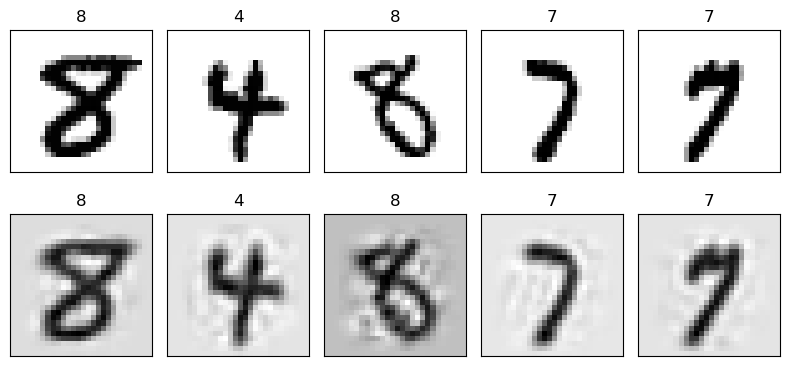

In [39]:
X2D = pca.fit_transform(X)
X3D_inv = pca.inverse_transform(X2D)

plt.rc("image", cmap="binary")
plt.figure(figsize=(8,4))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
for i in range(5):
    plt.subplot(2,5,5+i+1)
    plt.imshow(X3D_inv[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

Notice that the 5 digits from the first row are created from 768 components and the figures on the second row were back converted from the PCA with just 80 components.

---

# Acknowledgments

This notebook is based on a variety of sources, usually other notebooks, the material was adapted to the topics covered during lessons. In some cases, the original notebooks were created for Python 2.x or older versions of Scikit-learn or Tensorflow and they have to be adapted to at least Python 3.7. 
 
We acknowledge the support of the National Science Foundation and the US Department of Energy under projects: DMREF-NSF 1434897, NSF OAC-1740111 and DOE DE-SC0016176 is recognized.

<div style="clear: both; display: table;">
<div style="border: none; float: left; width: 40%; padding: 10px">
<img src="fig/NSF.jpg" alt="National Science Foundation" style="width:50%" align="left">
    </div>
    <div style="border: none; float: right; width: 40%; padding: 10px">
<img src="fig/DOE.jpg" alt="National Science Foundation" style="width:50%" align="right">
</div>

---

# References

The snippets above are meant only to give a brief introduction to some of the most popular techniques in machine learning so you can decide whether this kind of analysis might be useful in your research. If it seems like machine learning will be important in your work, you may want to check out some of the resources listed below (arranged roughly from least to most technical):

This list is by no means an exhaustive list of books and resources. I am listing the books from which I took inspiration. Also, I am listing materials where I found better ways to present topics. Often I am amazed by how people can create approachable materials for seemingly dry subjects.

The order of the books goes from divulgation and practical to the more rigorous and mathematical. Slides, blogs, and videos are those I have found over the internet or suggested by others.

### Selection of Books on Machine Learning

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Hands-On Machine Learning  with Scikit-Learn and TensorFlow" 
       src="./fig/books/Hands-On Machine Learning  with Scikit-Learn and TensorFlow.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Hands-On Machine Learning  with Scikit-Learn and TensorFlow (First Edition [There is a second edition])<br>
      Auréleien Géron<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Python Machine Learning - Raschka" 
       src="./fig/books/Python Machine Learning - Raschka.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Machine Learning, a Probabilistic Perspective<br>
      Sebastian Raschka and Vahid Mirjalili<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Foundations of Machine Learning - Mohri" 
       src="./fig/books/Foundations of Machine Learning - Mohri.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Foundations of Machine Learning (Second Edition)<br>
      Mehryar Mohri, Afshin Rostamizadeh and Ameet Talwalkar<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Machine Learning - Alpaydin" 
       src="./fig/books/Introduction to Machine Learning - Alpaydin.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Machine Learning (Fourth Edition)<br>
      Ethem Alpaydin<br>
      2020<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Machine Learning, a Probabilistic Perspective - Murphy" 
       src="./fig/books/Machine Learning, a Probabilistic Perspective - Murphy.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Machine Learning, a Probabilistic Perspective<br>
      Kevin P. Murphy<br>
      2012<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Elements of Statistical Learning - Hastie" 
       src="./fig/books/Elements of Statistical Learning - Hastie.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      <a href="https://hastie.su.domains/Papers/ESLII.pdf">Elements of Statistical Learning</a><br>
      Trevor Hastie, Robert Tibshirani, and Jerome Friedman<br>
      2008<br>
  </div>
</div>


### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelien Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml) and
   [Second Edition](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 

 * [A Friendly Introduction to Machine Learning](https://www.youtube.com/watch?v=IpGxLWOIZy4)

In this 30-minute video, Luis Serrano (head of machine learning at Udacity) offers intuitive, user-friendly introductions to the mechanics that drive several machine learning models, including Naive Bayes, Decision Tree, Logistic Regression, Neural Network, and Support Vector Machine classifiers. This video is a great place to start for those looking for quick intuitions about the ways these algorithms work.

 * [Hands-On Machine Learning with Scikit-Learn and TensorFlow (OREILLY)](http://shop.oreilly.com/product/0636920052289.do)

This OREILLY book offers a great high-level introduction to machine learning with Python. Aurélien Géron guides readers through ways one can use scikit-learn and other popular libraries to build machine learning models in Python. This is a great choice for those who just want to get work done, without necessarily unlocking the insights that would allow one to build models from scratch.

 * [Machine Learning Cheatsheets](https://becominghuman.ai/cheat-sheets-for-ai-neural-networks-machine-learning-deep-learning-big-data-678c51b4b463)

This collection of "cheat sheets" gives concise overviews of the API's and models behind many of the most prominent packages and concepts in machine learning and its allied fields, including different neural network architectures, numerical optimization techniques, algorithms appropriate for different tasks, scikit-learn, pandas, scikit-learn, scipy, ggpot2, dplyr and tidyr, big O notation, and several other topics. Recently identified as the "most popular" article on machine learning in Medium.

 * [Mining of Massive Datasets](http://www.mmds.org/)

This Stanford University course and digital publication offer introductions to a wide array of subtopics in machine learning. The authors focus on helping readers gain an intuitive understanding of how machine learning models work. One of the most lucid and concise treatments of machine learning available on the web.

 * [Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/)

This Stanford University course offers a spectacular introduction to Convolutional Neural Networks, the cornerstone of modern machine learning in the domain of computer vision. If your work involves images or video materials, and you'd like to apply machine learning techniques to your data, this course will help you get up and running with state-of-the-art techniques in convnets.

 * [Machine Learning (Andrew Ng, Coursera)](https://www.coursera.org/learn/machine-learning)

Andrew Ng's Coursera course on machine learning will help you master many of the fundamentals involved in modern machine learning. Professor Ng will guide you through a great deal of the math involved in contemporary machine learning, starting with simple linear classifiers and building up into complex neural network architectures. This class is ideal for those who like to understand the math behind the models they use.
 
 ---

# Back of the Book

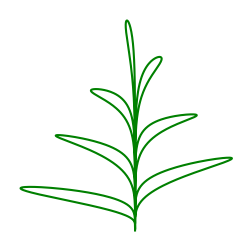

In [40]:
plt.figure(figsize=(3,3))
n = chapter_number
maxt=(2*(n-1)+3)*np.pi/2
t = np.linspace(np.pi/2, maxt, 1000)
tt= 1.0/(t+0.01)
x = (maxt-t)*np.cos(t)**3
y = t*np.sqrt(np.abs(np.cos(t))) + np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [41]:
end = time.time()
print(f'Chapter {chapter_number} run in {int(end - start):d} seconds')

Chapter 7 run in 45 seconds
